In [1]:
# import libraries
import math
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing
import itertools
import torch
import random
import time

# import Koopman Libraries
from core.koopman_core import KoopDNN, KoopmanNet, KoopmanNetCtrl

from sklearn import preprocessing
from core.util import fit_standardizer
from models.koop_model import model_matricies,lift

# Import Adaptive Koopman
from core.adapt_net_linear import AdaptNet_linear
import scipy.io


from dynamics.sync_pendulum import sync_pendulum_data_gen_multi, FK_solver

## System Generation

In [2]:
bilinear = True

## Data Generation

In [3]:
# define system pars
sys_pars = {}
N = 5
num_states = 2*N
num_inputs = 1
dt = 0.01
sys_pars['num_states'] = num_states
sys_pars['num_inputs'] = num_inputs

sys_pars['N'] = N  #number of pendulums
sys_pars['f_origin'] = 0
sys_pars['m'] = 0.017
sys_pars['l'] = 0.1
sys_pars['gamma'] = 3.1956332e-4
sys_pars['b'] = 6.819e-4
sys_pars['k'] = 0.079
sys_pars['J'] = sys_pars['m']*sys_pars['l']**2
sys_pars['g'] = 9.81
sys_pars['dt'] = dt

adj_mat = np.diag(np.ones((N-1)), 1) + np.diag(np.ones((N-1)), -1)
L = np.diag(sum(adj_mat)) - adj_mat
sys_pars['L'] = L
sys_pars['d'] = np.hstack((np.array([1]),np.zeros((N-1)))).reshape((N,-1))
sys_pars['F_type'] = 'sinusoidal' #type of inputs used to generate data
sys_pars['F_max'] = 0.1 #maximum amplitude of torque to generate dataset

sys_pars['uncertainty'] = 'NA'
sys_pars['amp_frac'] = 0



In [4]:
# # system pars
sys_pars_new = {} #system parameters for the uncertain system
percent_change = 10 #percentage change in the parameters of the system

sys_pars_new['num_states'] = num_states
sys_pars_new['num_inputs'] = num_inputs

sys_pars_new['N'] = N
sys_pars_new['f_origin'] = sys_pars['f_origin']
sys_pars_new['m'] = sys_pars['m'] * (1 + random.choice([-1,1])*percent_change/100)
sys_pars_new['l'] = sys_pars['l'] * (1 + random.choice([-1,1])*percent_change/100)
sys_pars_new['gamma'] = sys_pars['gamma'] * (1 + random.choice([-1,1])*percent_change/100)
sys_pars_new['b'] = sys_pars['b'] * (1 + random.choice([-1,1])*percent_change/100)
sys_pars_new['k'] = sys_pars['k'] * (1 + random.choice([-1,1])*percent_change/100)
sys_pars_new['J'] = sys_pars_new['m']*sys_pars_new['l']**2
sys_pars_new['g'] = sys_pars['g']
sys_pars_new['F_max'] = sys_pars['F_max']
sys_pars_new['dt'] = dt
sys_pars_new['L'] = L
sys_pars_new['d'] = sys_pars['d']
sys_pars_new['F_type'] = sys_pars['F_type']

sys_pars_new['uncertainty'] = 'NA' #['NA','periodic','constant']
sys_pars_new['amp'] = 0.05 #amplitude of torque disturbance
sys_pars_new['freq'] = 5 #[5,10,100,500.1000] frequency of periodic disturbance

sensor_noise = False
SNR_DB = 30 #[20,25,30,35,40] #signal-to-noise ration of sensor noise

In [5]:
num_traj = 100
num_train = int(0.75*num_traj)
num_val = num_traj - num_train

num_snaps = 800

In [6]:
X, X_changed, U = sync_pendulum_data_gen_multi(num_traj, num_snaps, sys_pars, sys_pars_new,sensor_noise, SNR_DB)

In [7]:
X.shape, X_changed.shape, U.shape

((100, 800, 10), (100, 800, 10), (100, 799, 1))

In [8]:
if sys_pars_new['uncertainty'] == 'constant':
    img_pth = 'saved_models/sync_pendulum/nonparametric/constant/linear/' + str(sys_pars_new['amp_frac']) +'/'
elif sys_pars_new['uncertainty'] == 'periodic':
    img_pth = 'saved_models/sync_pendulum/nonparametric/periodic/linear/' + str(sys_pars_new['amp_frac']) +'/'
else:
    if sensor_noise:
        img_pth = 'saved_models/sync_pendulum/bilinear/parametric/sensor_noise/'+str(percent_change)+'/'+str(SNR_DB)
    else:
        img_pth = 'saved_models/sync_pendulum/bilinear/parametric/no_sensor_noise/'

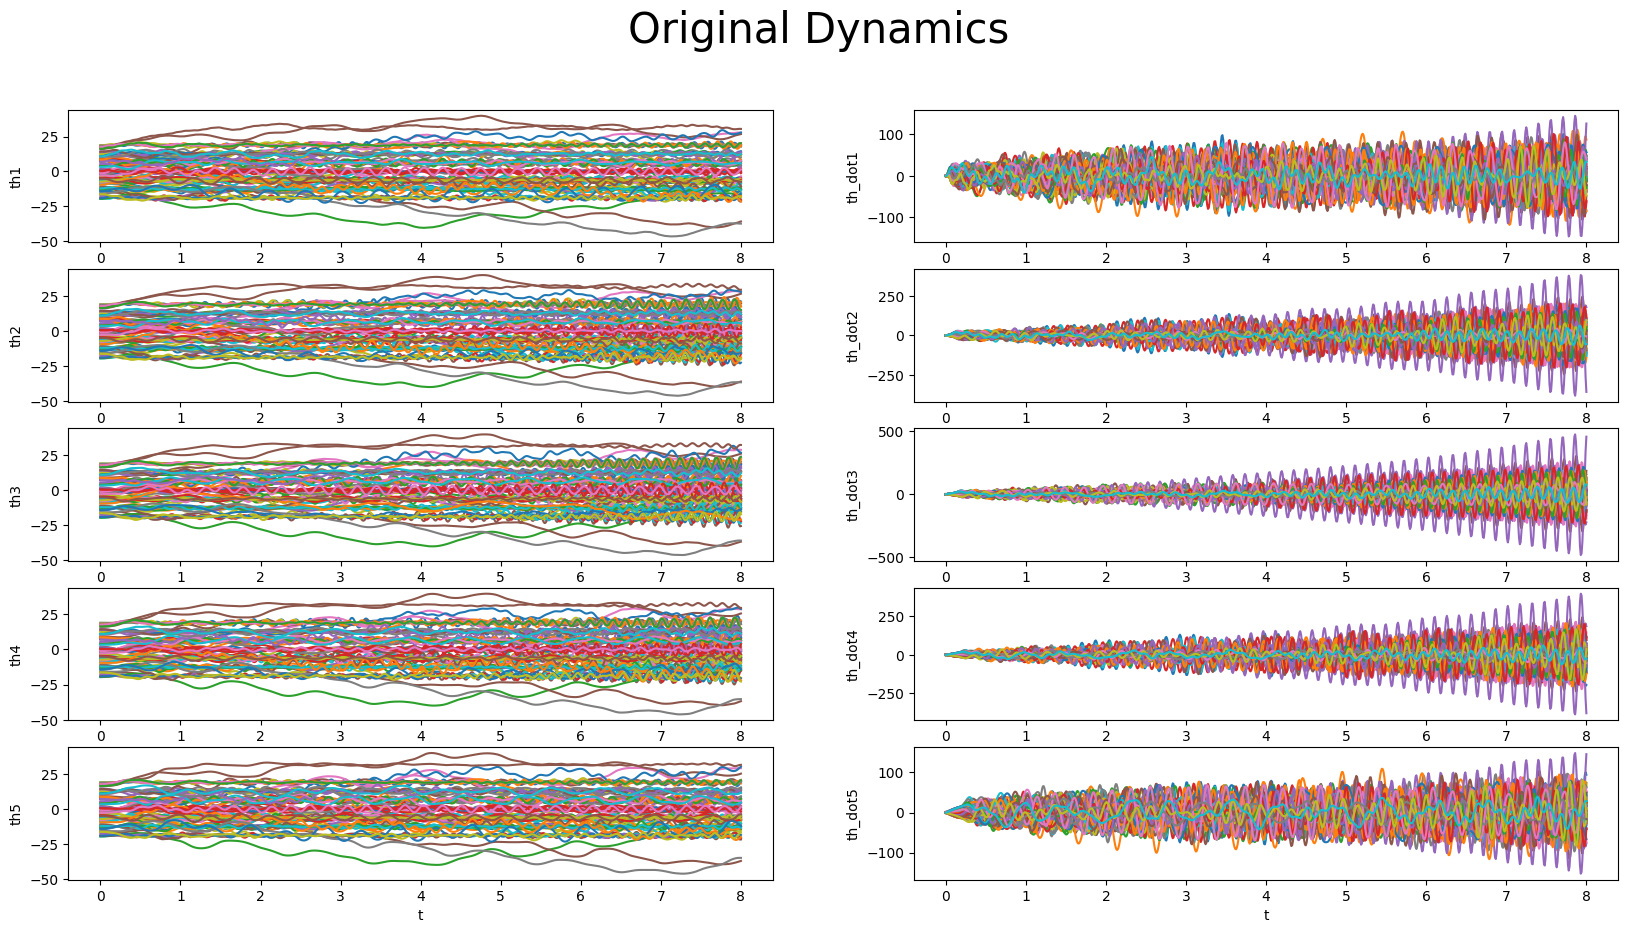

In [9]:
# Overall data
leg = ['th','th_dot']
t_train = np.linspace(0,dt*num_snaps,num_snaps)
plt.figure(figsize = (20,10))
for j in range(num_traj):
    for i in range(N):
        plt.subplot(N,2,2*i+1)
        plt.xlabel("t")
        plt.ylabel(leg[0]+str(i+1))
        plt.plot(t_train,X[j,:,2*i])

        plt.subplot(N,2,2*i+2)
        plt.xlabel("t")
        plt.ylabel(leg[1]+str(i+1))
        plt.plot(t_train,X[j,:,2*i+1])

plt.suptitle("Original Dynamics", fontsize=30)
plt.show()

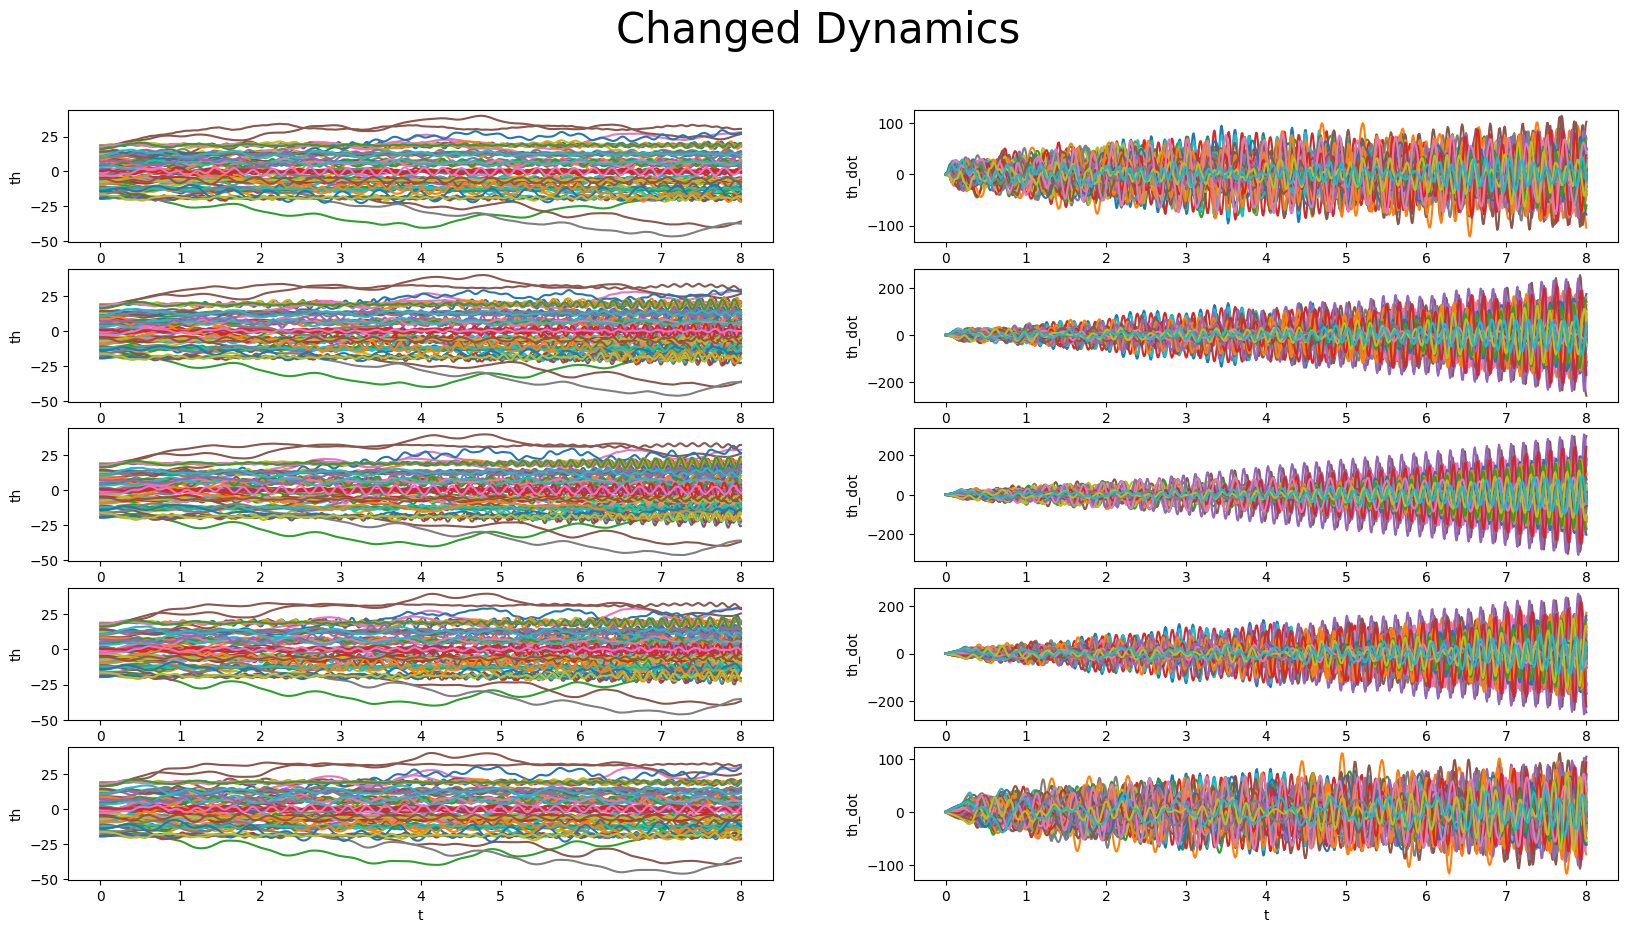

In [10]:
plt.figure(figsize = (20,10))
for j in range(num_traj):
    for i in range(N):
        plt.subplot(N,2,2*i+1)
        plt.xlabel("t")
        plt.ylabel(leg[0])
        plt.plot(t_train,X[j,:,2*i])

        plt.subplot(N,2,2*i+2)
        plt.xlabel("t")
        plt.ylabel(leg[1])
        plt.plot(t_train,X_changed[j,:,2*i+1])

plt.suptitle("Changed Dynamics", fontsize=30)
plt.show()

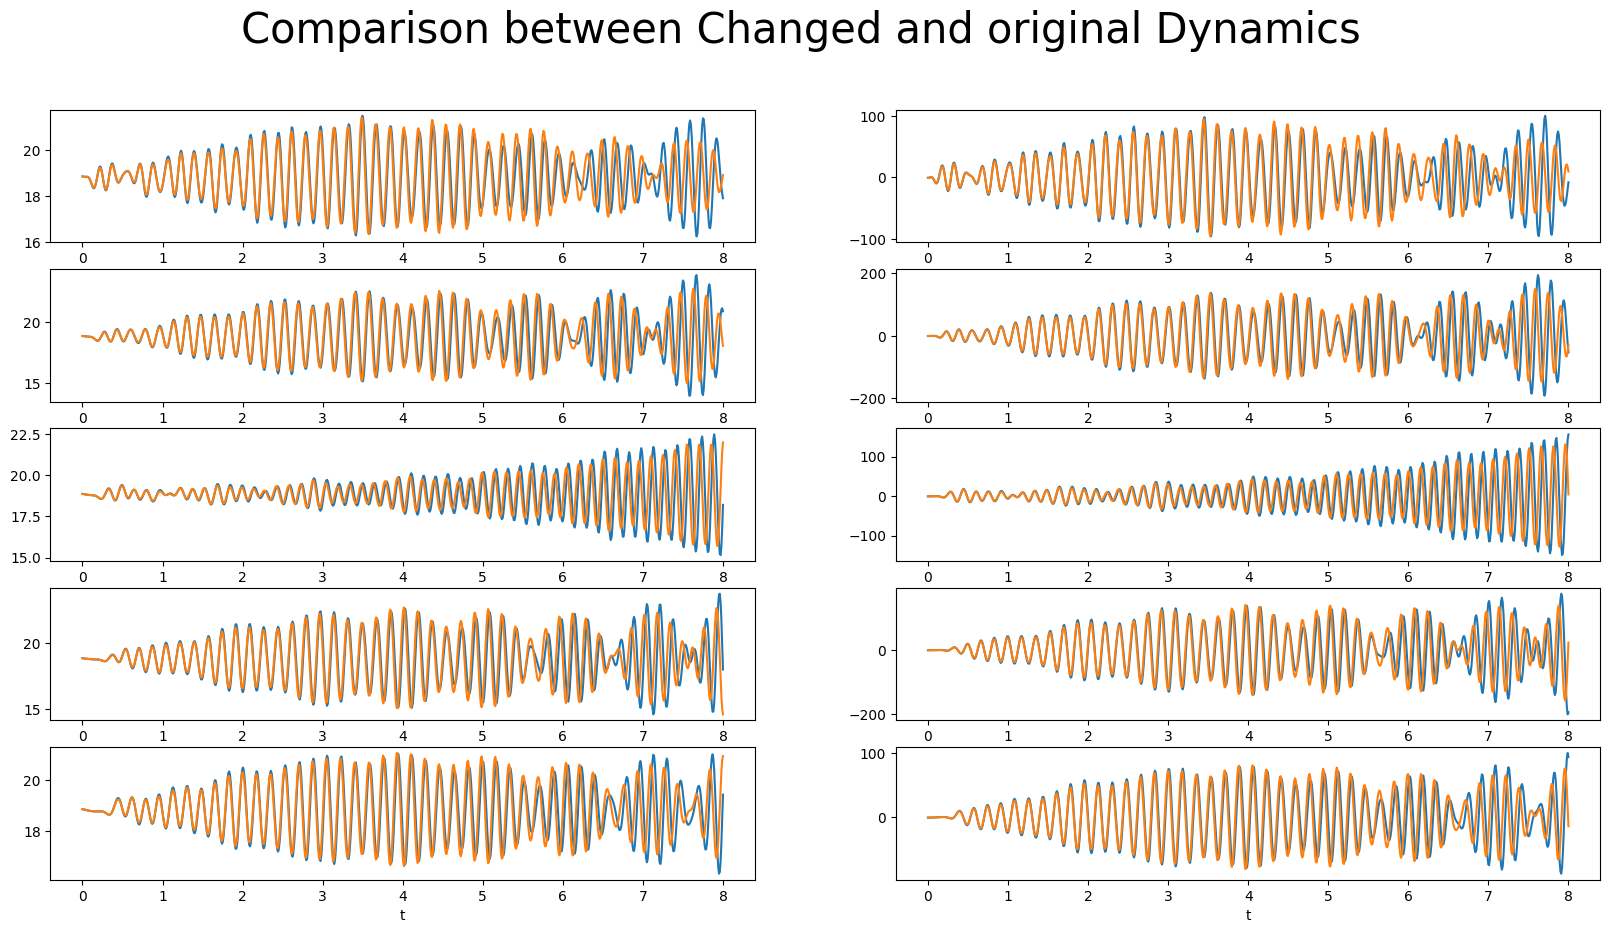

In [11]:
plt.figure(figsize = (20,10))
j = 10
for i in range(num_states):
    plt.subplot(N,2,i+1)
    plt.plot(t_train,X[j,:,i])
    plt.plot(t_train,X_changed[j,:,i])
    plt.xlabel("t")
    # plt.ylabel(leg[i])
plt.suptitle("Comparison between Changed and original Dynamics", fontsize=30)
plt.show()

Text(0.5, 0.98, 'Control Inputs')

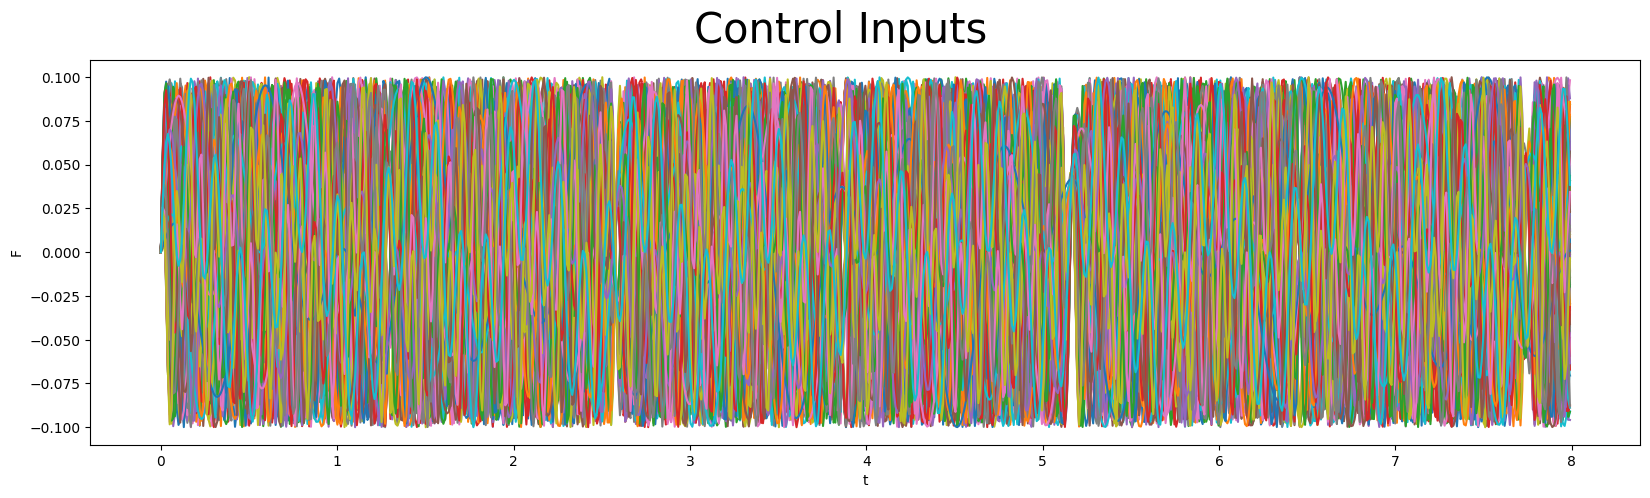

In [12]:
plt.figure(figsize = (20,5))
for j in range(num_traj):
    for i in range(int(num_inputs)):
        plt.subplot(num_inputs,1,i+1)
        plt.xlabel("t")
        plt.ylabel("F")
        plt.plot(t_train[:-1], U[j,:,i])
plt.suptitle("Control Inputs", fontsize=30)

## Learning Koopman Models

In [13]:
# split training and vaidation datasets
xs_train, us_train = X[:num_train,:,:],U[:num_train,:,:]
xs_val, us_val = X[num_train:,:,:],U[num_train:,:,:]

In [14]:
xs_train.shape, us_train.shape

((75, 800, 10), (75, 799, 1))

In [15]:
# auto encoder parameters
net_params_bilin = {}
net_params_bilin['state_dim'] = num_states
net_params_bilin['ctrl_dim'] = num_inputs
net_params_bilin['encoder_hidden_width'] = 60
net_params_bilin['encoder_hidden_depth'] = 3
net_params_bilin['encoder_output_dim'] = 6
net_params_bilin['optimizer'] = 'adam'
net_params_bilin['activation_type'] = 'tanh'
net_params_bilin['lr'] = 2e-4 # 5e-4
net_params_bilin['epochs'] = 200
net_params_bilin['batch_size'] = 256
net_params_bilin['lifted_loss_penalty'] = 0.4
net_params_bilin['l2_reg'] = 1e-5
net_params_bilin['l1_reg'] = 1e-5
net_params_bilin['first_obs_const'] = True
net_params_bilin['override_C'] = True # this makes the state a part of lifted state
net_params_bilin['dt'] = dt

In [16]:
# Koopman Model
train = False
standardize = False
file_koop_bilinear = 'saved_models/sync_pendulum/bilinear/Koop_arch_N'+str(N)+'_L'+ str(sys_pars['l']) +'_Dim'+ str(net_params_bilin['encoder_output_dim'])+'_dt_'+str(dt)+'.pth'

In [17]:
file_koop_bilinear

'saved_models/sync_pendulum/bilinear/Koop_arch_N5_L0.1_Dim6_dt_0.01.pth'

In [18]:
standardizer_u_kdnn = fit_standardizer(us_train, preprocessing.StandardScaler(with_mean = True))
standardizer_x_kdnn = fit_standardizer(xs_train, preprocessing.StandardScaler(with_mean = False))

In [19]:

if train == True:
    if standardize:
        net = KoopmanNetCtrl(net_params_bilin, standardizer_x=standardizer_x_kdnn, standardizer_u=standardizer_u_kdnn)
    else:
        net = KoopmanNetCtrl(net_params_bilin)
    model_koop_dnn_bilin = KoopDNN(net)
    model_koop_dnn_bilin.set_datasets(xs_train, u_train=us_train, x_val=xs_val, u_val=us_val)
    model_koop_dnn_bilin.model_pipeline(net_params_bilin)
    model_koop_dnn_bilin.construct_koopman_model()
    torch.save(model_koop_dnn_bilin,file_koop_bilinear)
else:
    model_koop_dnn_bilin = torch.load(file_koop_bilinear)

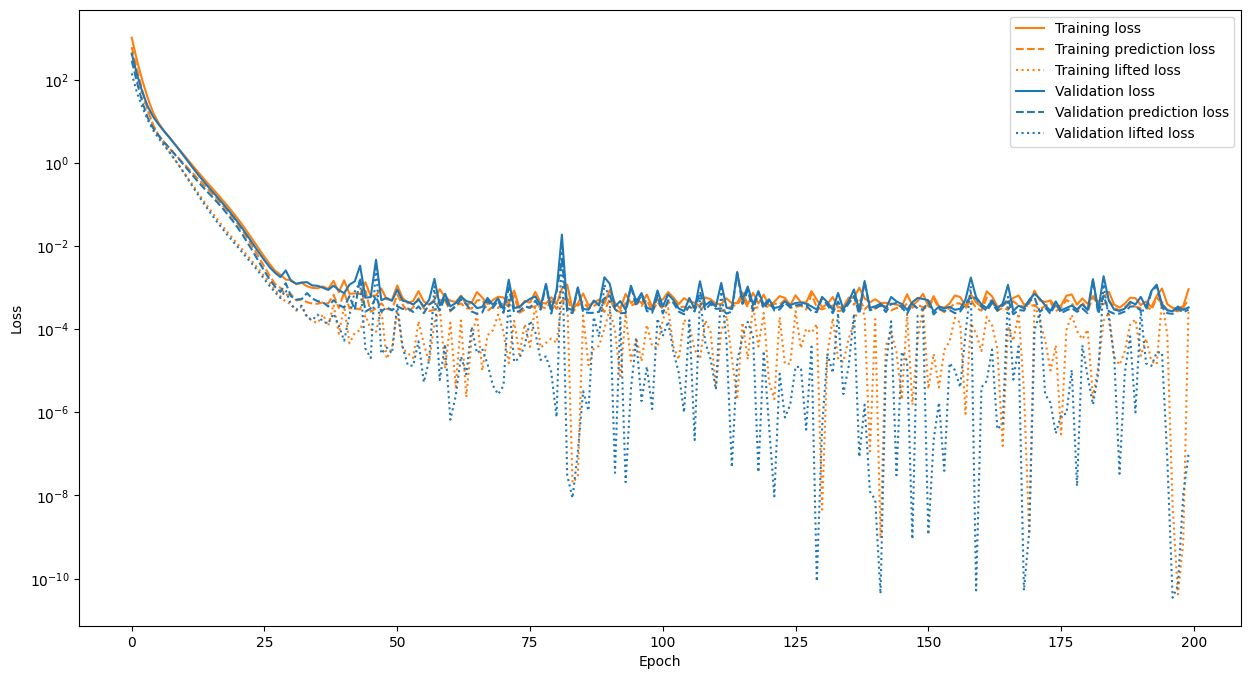

In [20]:
train_loss = [l[0] for l in model_koop_dnn_bilin.train_loss_hist]
train_pred_loss = [l[1] for l in model_koop_dnn_bilin.train_loss_hist]
train_lifted_loss = [l[2] for l in model_koop_dnn_bilin.train_loss_hist]
val_loss = [l[0] for l in model_koop_dnn_bilin.val_loss_hist]
val_pred_loss = [l[1] for l in model_koop_dnn_bilin.val_loss_hist]
val_lifted_loss = [l[2] for l in model_koop_dnn_bilin.val_loss_hist]
epochs = np.arange(0, net_params_bilin['epochs'])

plt.figure(figsize=(15,8))
plt.plot(epochs, train_loss, color='tab:orange', label='Training loss')
plt.plot(epochs, train_pred_loss, '--', color='tab:orange', label='Training prediction loss')
plt.plot(epochs, train_lifted_loss, ':', color='tab:orange', label='Training lifted loss')
plt.plot(epochs, val_loss, color='tab:blue', label='Validation loss')
plt.plot(epochs, val_pred_loss, '--', color='tab:blue', label='Validation prediction loss')
plt.plot(epochs, val_lifted_loss, ':', color='tab:blue', label='Validation lifted loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

## Koopman Model Parameters

In [21]:
# test data parameters
num_snaps_test = 1000 # no. of snapshots
T_test = np.linspace(0,(num_snaps_test-1)*dt, num_snaps_test)
num_traj_test = 1 # no. of training examples
first_obs_const = int(net_params_bilin['first_obs_const']) #only one state
override_C = net_params_bilin['override_C']
if override_C:
    n_obs_bilin = int(net_params_bilin['encoder_output_dim']) + num_states + first_obs_const
else:
    n_obs_bilin = int(net_params_bilin['encoder_output_dim']) + first_obs_const

In [22]:
x_unchanged_test, x_changed_test, u_test = sync_pendulum_data_gen_multi(num_traj_test, num_snaps_test, sys_pars, sys_pars_new, sensor_noise, SNR_DB)

In [23]:
A_bilin = np.array(model_koop_dnn_bilin.A)
B_bilin = np.array(model_koop_dnn_bilin.B)
C_bilin = np.array(model_koop_dnn_bilin.C)

print(A_bilin.shape, B_bilin.shape, C_bilin.shape)

X_unchanged,_ = model_koop_dnn_bilin.net.process(x_unchanged_test,data_u = u_test)
X_changed,_ = model_koop_dnn_bilin.net.process(x_changed_test,data_u = u_test)

(17, 17) (17, 17) (10, 17)


In [24]:
x_unchanged = X_unchanged[:, :num_states]
u = X_unchanged[:, num_states:num_states+num_inputs]
x_unchanged_prime = X_unchanged[:,num_states+num_inputs:]

x_changed = X_changed[:, :num_states]
x_changed_prime = X_changed[:,num_states+num_inputs:]

In [25]:
x_changed.shape, x_changed_prime.shape, x_unchanged.shape

((999, 10), (999, 10), (999, 10))

In [26]:
# initialize states
z_bilin = np.empty((n_obs_bilin,num_snaps_test+1)).T   #lifted state
x_est_bilin = np.zeros((num_states,num_snaps_test+1)).T #estimated values
z_bilin[0,:] = lift(x_unchanged[0,:],model_koop_dnn_bilin, net_params_bilin)
x_est_bilin[0,:] = x_unchanged[0,:]


In [27]:
for i in range(num_snaps_test-1):
    #bilinear
    z_bilin[i+1,:] = np.matmul(z_bilin[i,:],A_bilin.T)+np.matmul(np.kron(u[i,:],z_bilin[i,:]),B_bilin.T)
    x_est_bilin[i+1,:] = np.matmul(z_bilin[i+1,:],C_bilin.T)

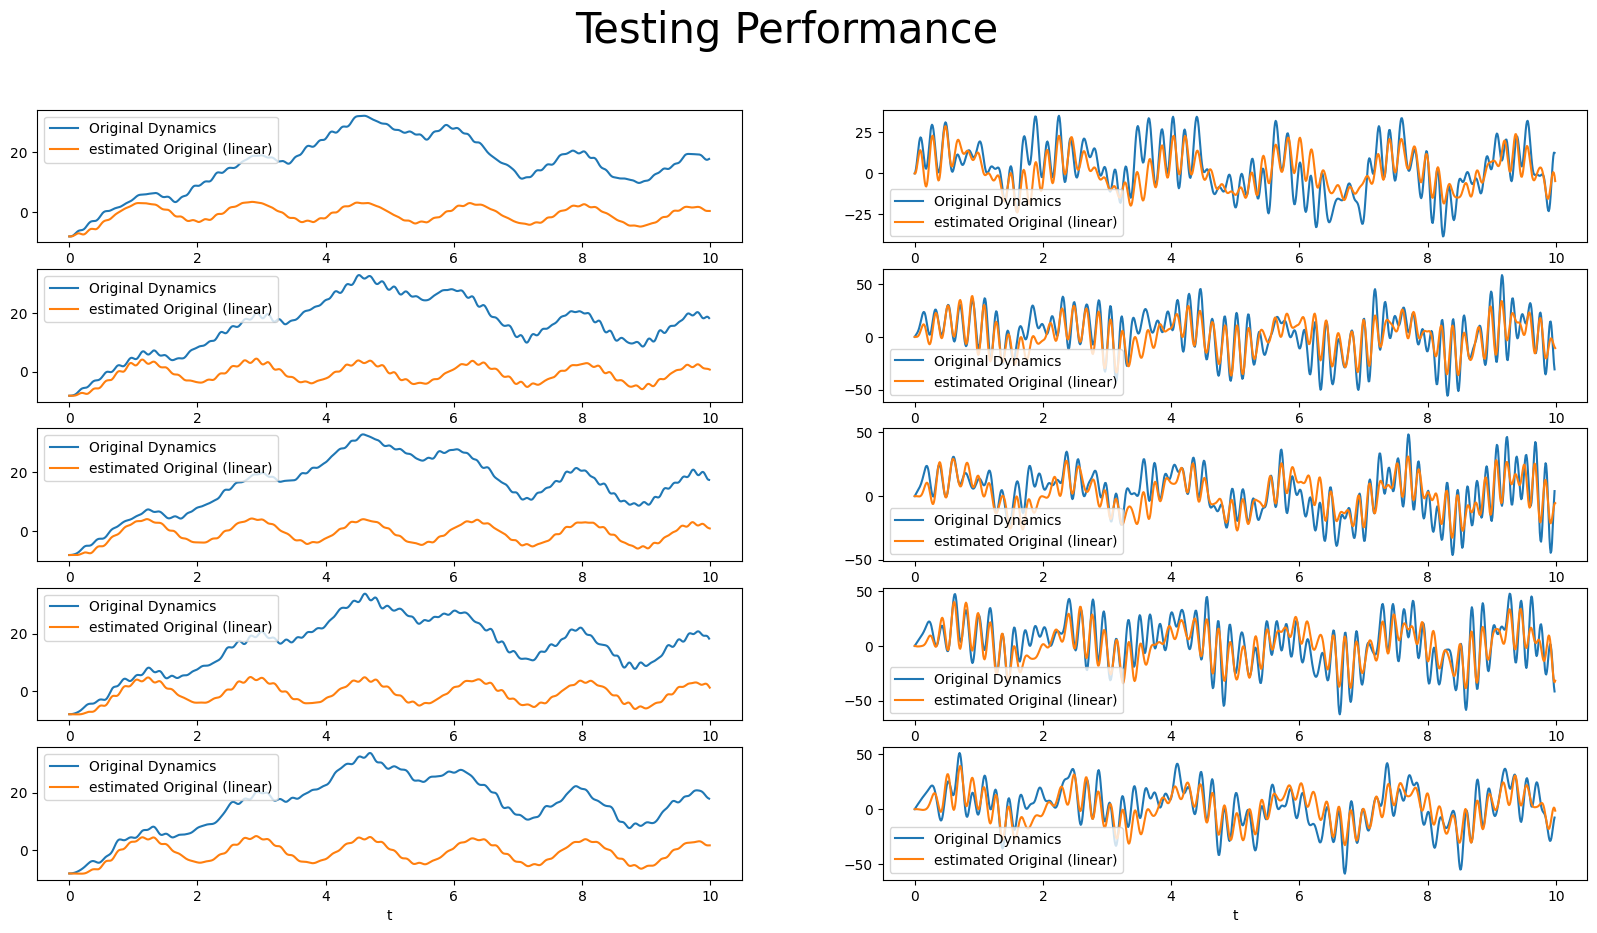

In [28]:
# state estimation evolution
plt.figure(figsize=(20, 10))
for i in range(int(num_states)):
    plt.subplot(N,2,i+1)
    plt.xlabel("t")
    # plt.ylabel(leg[i])
    plt.plot(T_test[:-1], x_unchanged[:,i],label ='Original Dynamics')
    plt.plot(T_test, x_est_bilin[:-1,i],label = 'estimated Original (linear)')
    plt.legend()
plt.suptitle("Testing Performance", fontsize=30)

plt.show()

## Testing

## Adaptive Koopman with Control

In [29]:
from core.adapt_net import AdaptNet

In [30]:
"""Simultaneous adaptation and control"""

'Simultaneous adaptation and control'

In [31]:
from control_files.nmpc_osqp_adapt import NonlinearMPCController
from control_files.bmpc_osqp_adapt import bilinearMPCController
from dynamics.learned_models_control.bilinear_dynamics import bilinear_Dynamics
from dynamics.learned_models_control.linear_dynamics import linear_Dynamics
import scipy

In [32]:
import time

In [33]:
T_traj = 20 #length of trajectory
offset = 0*np.array([5,1,1,0.5]) #initial offset

t_ref = np.arange(0, T_traj, dt)    # Simulation time points, closed loop
traj_length = t_ref.size
x_ref = np.zeros((num_states,traj_length))
phi_dot_ref = 40 #reference angular velocity
for i in range(traj_length):
    x_ref[::2,i] = phi_dot_ref*i*dt #reference angles
    x_ref[1::2,i] = phi_dot_ref #reference angular velocities

Text(0.5, 0.98, 'y ref traj')

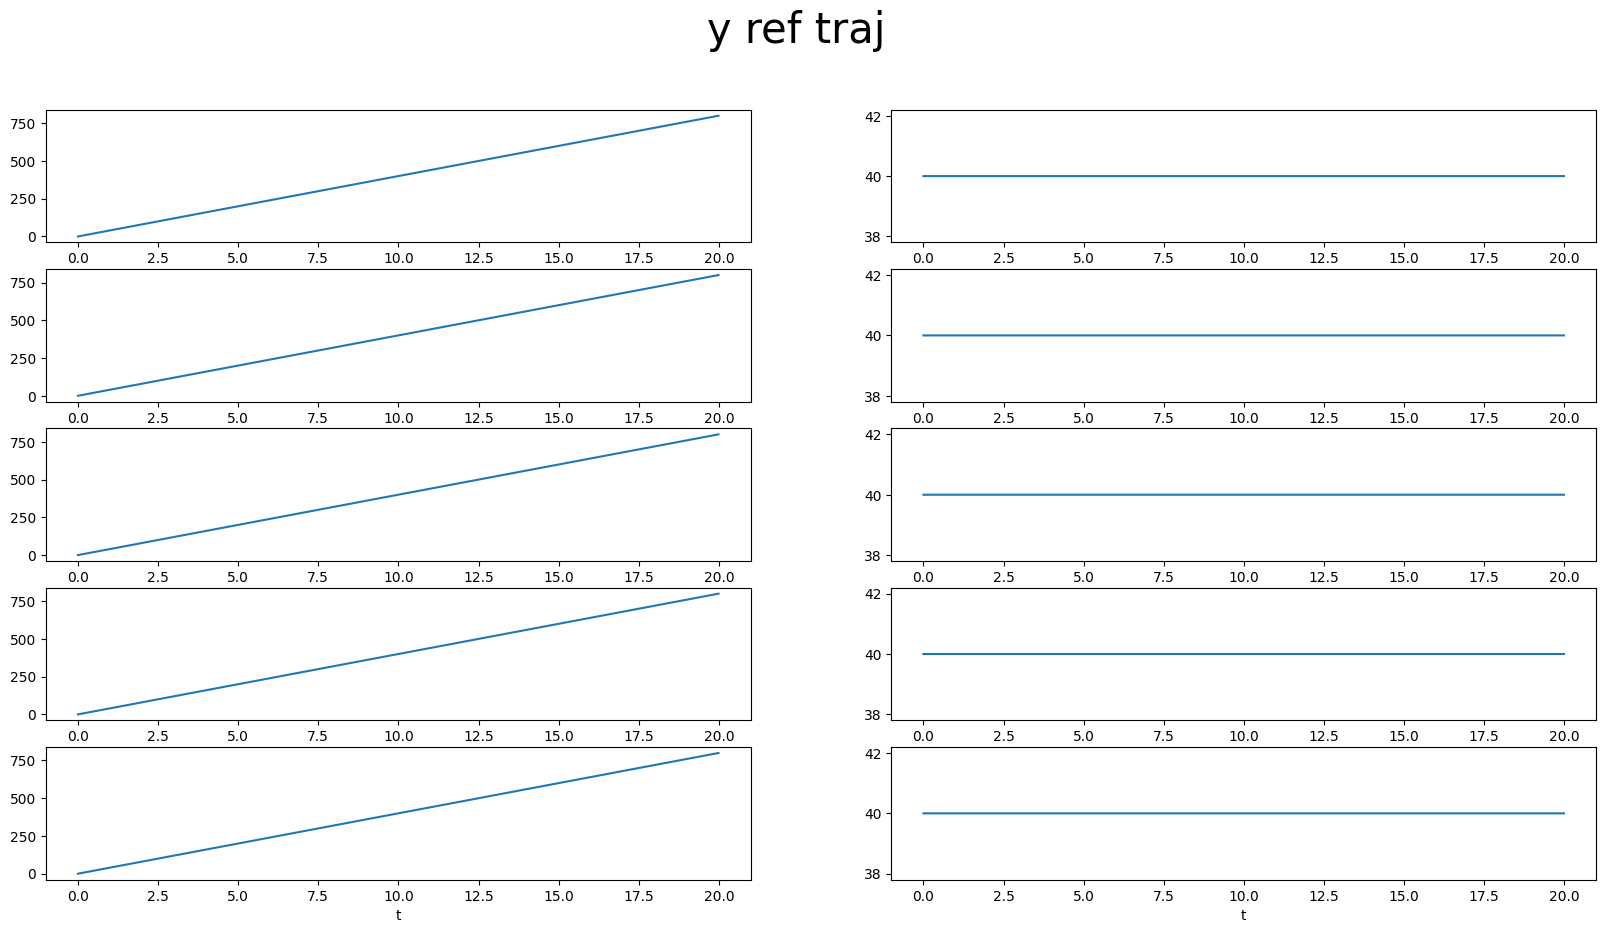

In [34]:
# state estimation evolution
leg_y = ['x','theta','x_dot', 'theta_dot']
plt.figure(figsize=(20, 10))
for i in range(num_states):
    plt.subplot(N,2,i+1)
    plt.xlabel("t")
    # plt.ylabel(leg_y[i])
    plt.plot(t_ref,x_ref[i,:])
plt.suptitle("y ref traj", fontsize=30)


In [35]:

if bilinear:
    begin_bilinear_noadapt = time.time()

    A_bilin = np.array(model_koop_dnn_bilin.A)
    B_bilin = np.array(model_koop_dnn_bilin.B)
    C_bilin = np.array(model_koop_dnn_bilin.C)

    solver_settings = {}
    solver_settings['gen_embedded_ctrl'] = False
    solver_settings['warm_start'] = True
    solver_settings['polish'] = True
    solver_settings['polish_refine_iter'] = 6
    solver_settings['scaling'] = True
    solver_settings['adaptive_rho'] = False
    solver_settings['check_termination'] = 25
    solver_settings['max_iter'] = 1000
    solver_settings['eps_abs'] = 1e-6
    solver_settings['eps_rel'] = 1e-6
    solver_settings['eps_prim_inf'] = 1e-4
    solver_settings['eps_dual_inf'] = 1e-4
    solver_settings['linsys_solver'] = 'qdldl'

    #controller that works on old model (unadapted)
    N_bilin_noadapt = 15 #length of horizon

    Q_mpc_bilin_noadapt = 10*scipy.sparse.diags(np.ones(num_states))                       # State penalty matrix, trajectory generation
    QN_mpc_bilin_noadapt = 15*scipy.sparse.diags(np.ones(num_states))         # Final state penalty matrix, trajectory generation
    R_mpc_bilin_noadapt = 10*scipy.sparse.eye(num_inputs)                       # Actuation penalty matrix, trajectory generation
    R0_mpc_bilin_noadapt = 10*scipy.sparse.csc_matrix(np.zeros(num_inputs))



    max_iter_bilin = 1


    xmax_bilin_noadapt = (phi_dot_ref*T_traj+50)*np.ones((num_states))                             # State constraints, trajectory generation
    xmin_bilin_noadapt = -xmax_bilin_noadapt
    umax_bilin_noadapt = 5*np.ones((num_inputs))
    umin_bilin_noadapt = -umax_bilin_noadapt


    xt_bilin_noadapt = np.empty((traj_length+1, num_states))
    xt_actual_bilin_noadapt = np.empty((traj_length, num_states))
    xt_bilin_noadapt[0,:] = xt_actual_bilin_noadapt[0,:] = 0*x_ref[:,0]

    x_init_bilin_noadapt = np.linspace(xt_bilin_noadapt[0,:], xt_bilin_noadapt[0,:], N_bilin_noadapt+1)
    u_init_bilin_noadapt = 1*np.ones((num_inputs, N_bilin_noadapt)).T

    n_lift = A_bilin.shape[0]
    z_init_bilin_noadapt = np.empty((N_bilin_noadapt+1, n_lift))
    z0 = lift(xt_bilin_noadapt[0,:], model_koop_dnn_bilin, net_params_bilin)
    for i in range(N_bilin_noadapt+1):
        z_init_bilin_noadapt[i,:] = lift(x_init_bilin_noadapt[i,:], model_koop_dnn_bilin, net_params_bilin)


    bilinear_model_no_adapt = bilinear_Dynamics(scipy.sparse.csc_matrix(A_bilin),scipy.sparse.csc_matrix(B_bilin), C_bilin)
    controller_nmpc_bilin_noadapt = NonlinearMPCController(bilinear_model_no_adapt, N_bilin_noadapt, dt, umin_bilin_noadapt, umax_bilin_noadapt, xmin_bilin_noadapt, xmax_bilin_noadapt, Q_mpc_bilin_noadapt, R_mpc_bilin_noadapt, QN_mpc_bilin_noadapt, solver_settings)


    controller_nmpc_bilin_noadapt.construct_controller(z_init_bilin_noadapt, u_init_bilin_noadapt, x_ref[:,0])

    xt_bilin_noadapt = np.empty((num_states,traj_length+1)).T
    xt_new_bilin_noadapt = np.empty((num_states,traj_length+1)).T
    xt_bilin_noadapt[0,:] = xt_new_bilin_noadapt[0,:] = xt_bilin_noadapt[0,:]
    u_bilin_noadapt = np.empty((num_inputs, traj_length)).T
    z_bilin_noadapt = np.empty((n_obs_bilin, traj_length+1)).T

    t_excess = 0
    for l in range(traj_length-1):
        # incorrect dynamics
        z_bilin_noadapt[l,:] = lift(xt_actual_bilin_noadapt[l,:], model_koop_dnn_bilin, net_params_bilin)

        controller_nmpc_bilin_noadapt.solve_to_convergence(x_ref[:,l+1], z_bilin_noadapt[l,:], controller_nmpc_bilin_noadapt.z_init, controller_nmpc_bilin_noadapt.u_init, max_iter = max_iter_bilin, eps = 1e-3)
        controller_nmpc_bilin_noadapt.update_initial_guess_()
        u_bilin_noadapt[l,:] = controller_nmpc_bilin_noadapt.cur_u[0,:]
        t1 = time.time()

        # adapted model
        xt_bilin_noadapt[l+1,:] = np.matmul(controller_nmpc_bilin_noadapt.z_N0, C_bilin.T)

        if sensor_noise:
            xt_actual_bilin_noadapt[l+1,:] = FK_solver(xt_actual_bilin_noadapt[l,:], u_bilin_noadapt[l,:], sys_pars_new, sensor_noise, SNR_DB, l)
        else:
            xt_actual_bilin_noadapt[l+1,:] = FK_solver(xt_actual_bilin_noadapt[l,:], u_bilin_noadapt[l,:], sys_pars_new)
        t2 = time.time()

        t_excess = (t2-t1) + t_excess
    end_bilinear_noadapt = time.time()
    time_bilinear_noadapt = (end_bilinear_noadapt - begin_bilinear_noadapt - t_excess)/traj_length

In [36]:
l

1998

In [37]:

if bilinear:
    begin_bilinear_adapt = time.time()
    model_koop_dnn_bilin = torch.load(file_koop_bilinear)

    A_bilin = np.array(model_koop_dnn_bilin.A)
    B_bilin = np.array(model_koop_dnn_bilin.B)
    C_bilin = np.array(model_koop_dnn_bilin.C)

    adapt_window_ctrl_bilin = 1 #hyperparameter

    adapt_params_control_bilin = {}
    adapt_params_control_bilin['state_dim'] = num_states
    adapt_params_control_bilin['ctrl_dim'] = num_inputs
    adapt_params_control_bilin['lift_dim'] = net_params_bilin["encoder_output_dim"]
    adapt_params_control_bilin['optimizer'] = 'adam'
    adapt_params_control_bilin['lr'] = 1e-5 # 5e-4
    adapt_params_control_bilin['epochs'] = 2
    adapt_params_control_bilin['batch_size'] = adapt_window_ctrl_bilin
    adapt_params_control_bilin['l2_reg'] = 5e-3
    adapt_params_control_bilin['l1_reg'] = 5e-3
    adapt_params_control_bilin['first_obs_const'] = net_params_bilin["first_obs_const"]
    adapt_params_control_bilin['override_C'] = net_params_bilin["override_C"] # this makes the state a part of lifted state
    adapt_params_control_bilin['warm_start'] = False


    del_A_ctrl_bilin = np.zeros_like(A_bilin)
    del_B_ctrl_bilin = np.zeros_like(B_bilin)

    bilinear_model_adapt = bilinear_Dynamics(scipy.sparse.csc_matrix(A_bilin),scipy.sparse.csc_matrix(B_bilin), C_bilin)


    solver_settings = {}
    solver_settings['gen_embedded_ctrl'] = False
    solver_settings['warm_start'] = True
    solver_settings['polish'] = True
    solver_settings['polish_refine_iter'] = 6
    solver_settings['scaling'] = True
    solver_settings['adaptive_rho'] = False
    solver_settings['check_termination'] = 25
    solver_settings['max_iter'] = 1000
    solver_settings['eps_abs'] = 1e-6
    solver_settings['eps_rel'] = 1e-6
    solver_settings['eps_prim_inf'] = 1e-4
    solver_settings['eps_dual_inf'] = 1e-4
    solver_settings['linsys_solver'] = 'qdldl'


    #Closed loop performance evaluation parameters:

    max_iter_bilin = 1

    N_bilin = N_bilin_noadapt #length of horizon                      # Simulation time points, closed loop
    Q_mpc_bilin = Q_mpc_bilin_noadapt                       # State penalty matrix, trajectory generation
    QN_mpc_bilin = QN_mpc_bilin_noadapt         # Final state penalty matrix, trajectory generation
    R_mpc_bilin = R_mpc_bilin_noadapt                       # Actuation penalty matrix, trajectory generation
    R0_mpc_bilin = R0_mpc_bilin_noadapt       # Final state penalty matrix, trajectory generation


    # Design trajectory:

    xmax_bilin = xmax_bilin_noadapt                      # State constraints, trajectory generation
    xmin_bilin = xmin_bilin_noadapt
    umax_bilin = umax_bilin_noadapt
    umin_bilin = umin_bilin_noadapt

    x_new_dyn_bilin = np.empty((num_states, traj_length)).T #estimated values
    x_new_dyn_bilin[0,:]  = 0*x_ref[:,0]

    # Define initial solution for SQP algorithm:
    x_init_bilin = np.linspace(x_new_dyn_bilin[0,:], x_new_dyn_bilin[0,:], N_bilin+1)
    u_init_bilin = 0.1*np.ones((num_inputs, N_bilin)).T

    n_lift_bilin = A_bilin.shape[0]
    z_init_bilin = np.empty((N_bilin+1, n_lift_bilin))
    z0_bilin = lift(x_new_dyn_bilin[0,:], model_koop_dnn_bilin, net_params_bilin)
    for i in range(N_bilin+1):
        z_init_bilin[i,:] = lift(x_init_bilin[i,:], model_koop_dnn_bilin, net_params_bilin)

    # initialize state matricies
    u_ctrl_bilin = np.zeros((traj_length, num_inputs))
    z_new_dyn_bilin = np.empty((n_obs_bilin, traj_length+1)).T   #lifted state
    zt_old_dyn_bilin = np.empty((n_obs_bilin, traj_length+1)).T #actual lifted state
    zu_old_dyn_bilin = np.empty((n_obs_bilin * num_inputs, traj_length+1)).T #actual lifted state
    del_z_prime_ctrl_bilin = np.empty((n_obs_bilin, traj_length)).T

    del_A_norm_ctrl_bilin = np.zeros((traj_length,1))
    del_B_norm_ctrl_bilin = np.zeros((traj_length,1))

    # initialize
    z_new_dyn_bilin[0,:] = zt_old_dyn_bilin[0,:] = z0_bilin

    #controller that works on adapting model
    controller_nmpc_adapt = NonlinearMPCController(bilinear_model_adapt, N_bilin, dt, umin_bilin, umax_bilin, xmin_bilin, xmax_bilin, Q_mpc_bilin, R_mpc_bilin, QN_mpc_bilin, solver_settings)


    controller_nmpc_adapt.construct_controller(z_init_bilin, u_init_bilin, x_ref[:,0])

    t_excess = 0

    for j in range(traj_length-1):
        # incorrect dynamics
        z_new_dyn_bilin[j,:] = lift(x_new_dyn_bilin[j,:], model_koop_dnn_bilin, net_params_bilin)

        del_z_prime_ctrl_bilin[j,:] = z_new_dyn_bilin[j,:] - zt_old_dyn_bilin[j,:]
        zu_old_dyn_bilin[j,:] = np.kron(u_ctrl_bilin[j,:], zt_old_dyn_bilin[j,:])

        if j < adapt_window_ctrl_bilin + 1 :
            del_A = np.zeros_like(A_bilin)
            del_B = np.zeros_like(B_bilin)
        else:
            del_Z_prime = del_z_prime_ctrl_bilin[j-adapt_window_ctrl_bilin:j,:].T
            Z_old = zt_old_dyn_bilin[j-(adapt_window_ctrl_bilin+1):j-1].T
            ZU_old = zu_old_dyn_bilin[j-(adapt_window_ctrl_bilin+1):j-1].T

            #invoke neural net for adapation
            adapt_network = AdaptNet(adapt_params_control_bilin)
            adapt_network.model_pipeline(Z_old, ZU_old, del_Z_prime, print_epoch = True)
            del_A_ctrl_bilin, del_B_ctrl_bilin = adapt_network.get_del_matrices()

        del_A_norm_ctrl_bilin[j] = np.linalg.norm(del_A_ctrl_bilin)
        del_B_norm_ctrl_bilin[j] = np.linalg.norm(del_B_ctrl_bilin)

        bilinear_model_adapt.A = scipy.sparse.csc_matrix(bilinear_model_adapt.A.toarray() + del_A_ctrl_bilin)
        bilinear_model_adapt.B = scipy.sparse.csc_matrix(bilinear_model_adapt.B.toarray() + del_B_ctrl_bilin)

        controller_nmpc_adapt.solve_to_convergence(x_ref[:,j+1], z_new_dyn_bilin[j,:], controller_nmpc_adapt.z_init, controller_nmpc_adapt.u_init, max_iter = max_iter_bilin, eps = 1e-3)
        controller_nmpc_adapt.update_initial_guess_()
        u_ctrl_bilin[j,:] = controller_nmpc_adapt.cur_u[0,:]

        t1 = time.time()

        # adapted model
        zt_old_dyn_bilin[j+1,:] = controller_nmpc_adapt.z_N0


        if sensor_noise:
            x_new_dyn_bilin[j+1,:] = FK_solver(x_new_dyn_bilin[j,:], u_ctrl_bilin[j,:], sys_pars_new, sensor_noise, SNR_DB, j)
        else:
            x_new_dyn_bilin[j+1,:] = FK_solver(x_new_dyn_bilin[j,:], u_ctrl_bilin[j,:], sys_pars_new)

        t2 = time.time()
        t_excess = (t2-t1) + t_excess

    end_bilinear_adapt = time.time()
    time_bilinear_adapt = (end_bilinear_adapt - begin_bilinear_adapt - t_excess)/traj_length

In [38]:
j

1998

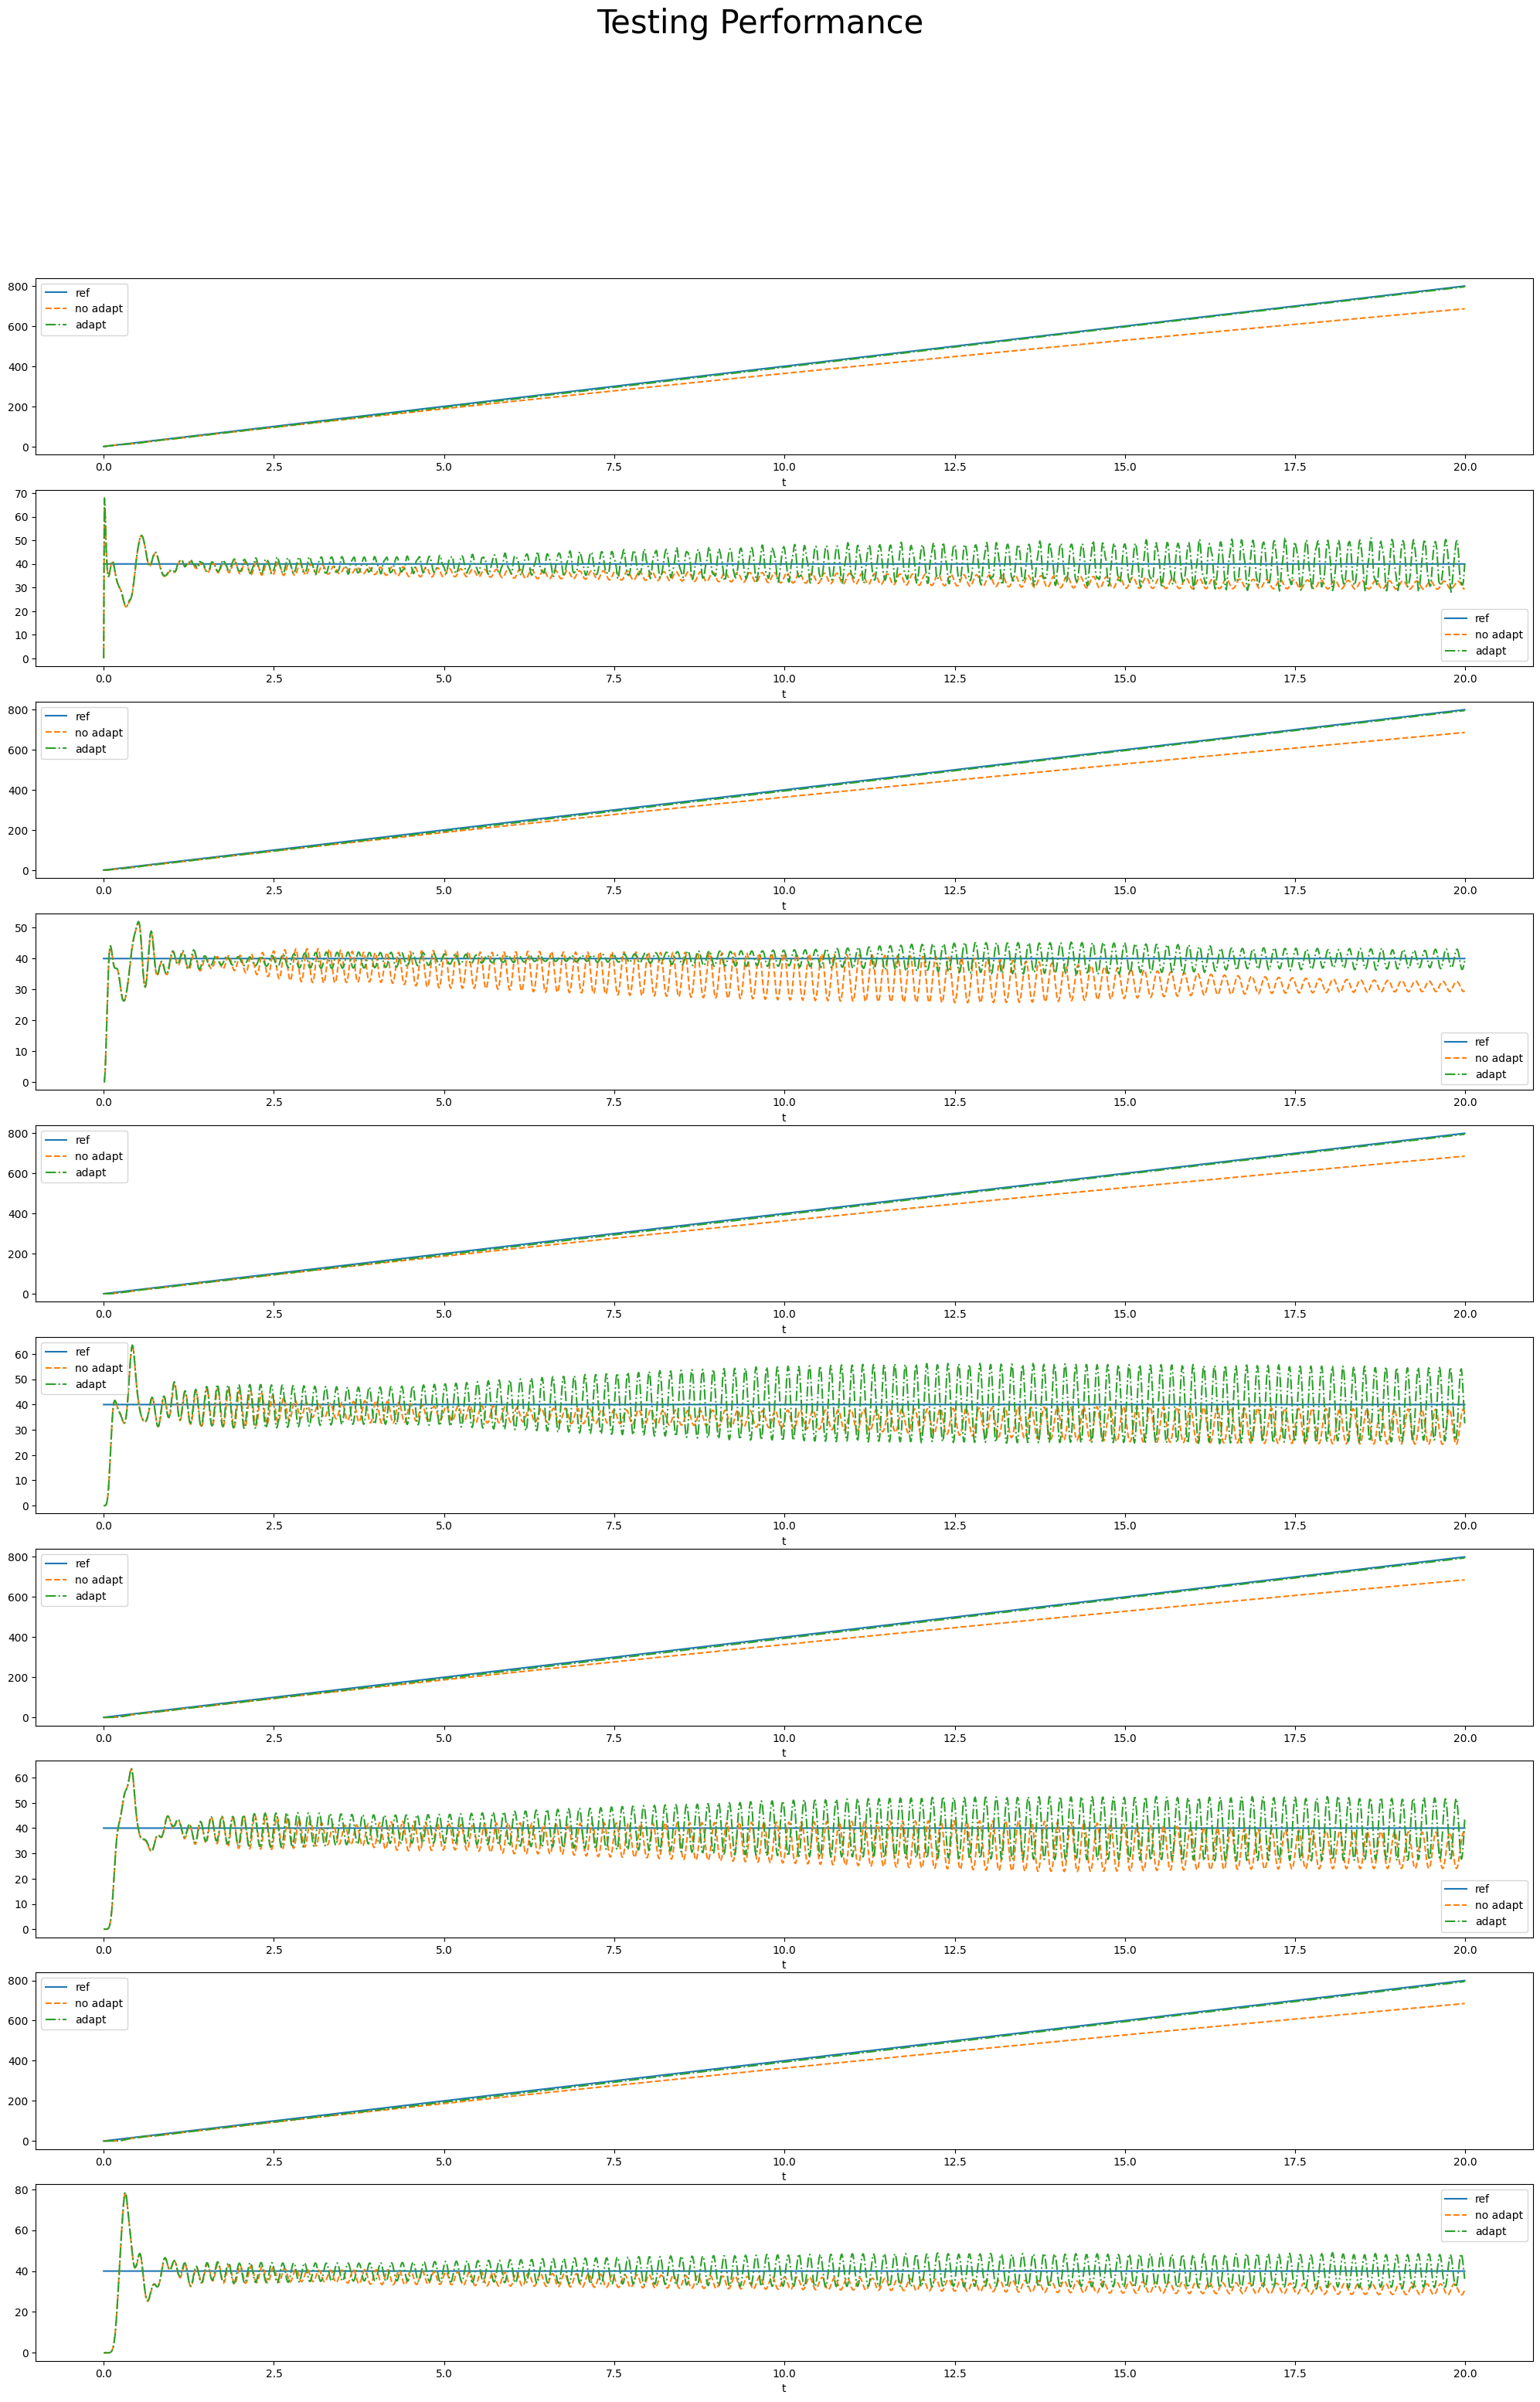

In [39]:
# state estimation evolution
plt.figure(figsize=(25,35))
for i in range(int(num_states)):
    plt.subplot(num_states,1,i+1)
    plt.xlabel("t")
    # plt.ylabel(leg[i])
    plt.plot(t_ref, x_ref[i,:], label = 'ref')
    plt.plot(t_ref, xt_actual_bilin_noadapt[:,i],'--',label = "no adapt")
    plt.plot(t_ref, x_new_dyn_bilin[:,i],'-.', label = "adapt")
    plt.legend()
plt.suptitle("simultaneous adaptation and control", fontsize=30)
plt.suptitle("Testing Performance", fontsize=30)

plt.show()

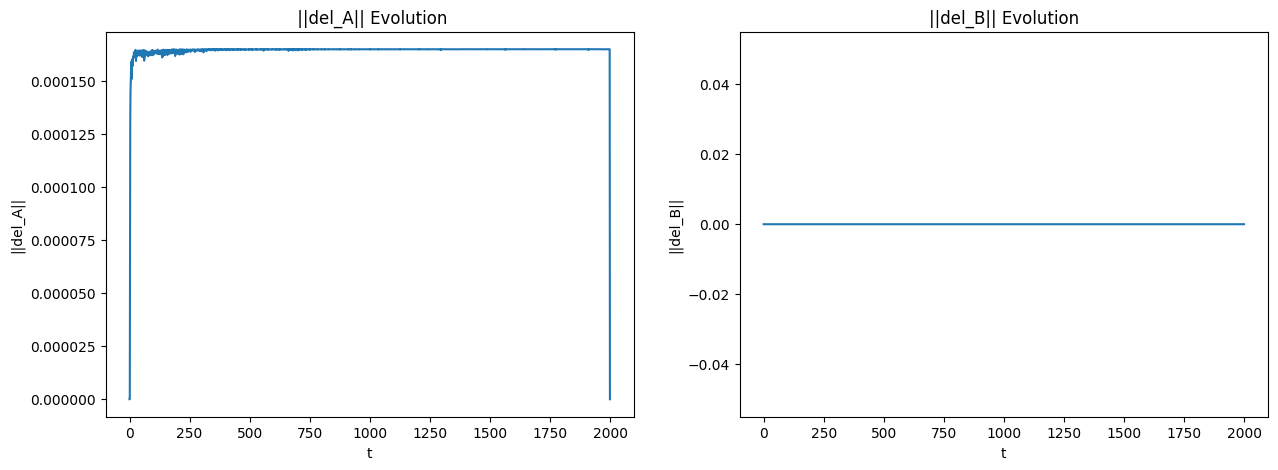

In [40]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].set_title(" ||del_A|| Evolution")
axs[1].set_title("||del_B|| Evolution")

axs[0].set(xlabel = 't', ylabel = '||del_A||')
axs[1].set(xlabel = 't', ylabel = '||del_B||')


axs[0].plot(del_A_norm_ctrl_bilin)

axs[1].plot(del_B_norm_ctrl_bilin)

plt.show()

In [41]:
x_new_dyn_bilin.shape, x_ref.shape

((2000, 10), (10, 2000))

In [42]:
from prettytable import PrettyTable
import pandas as pd

In [43]:
error_adapt_bilin = x_new_dyn_bilin - x_ref.T
error_noadapt_bilin = xt_actual_bilin_noadapt - x_ref.T

In [44]:
error_adapt_bilin_norm = np.linalg.norm(error_adapt_bilin, axis = 0)/np.sqrt(t_ref.shape)
error_noadapt_bilin_norm = np.linalg.norm(error_noadapt_bilin, axis = 0)/np.sqrt(t_ref.shape)


In [45]:
frac_imp = abs(error_adapt_bilin_norm - error_noadapt_bilin_norm)/error_noadapt_bilin_norm

In [46]:
mean_theta_no_adapt = np.sum(error_noadapt_bilin_norm[0::2])/N
mean_theta_dot_no_adapt = np.sum(error_noadapt_bilin_norm[1::2])/N

mean_theta_adapt = np.sum(error_adapt_bilin_norm[0::2])/N
mean_theta_dot_adapt = np.sum(error_adapt_bilin_norm[1::2])/N

mean_theta_frac = np.sum(frac_imp[0::2])/N
mean_theta_dot_frac = np.sum(frac_imp[1::2])/N

mean_frac_imp = np.sum(frac_imp)/2/N

In [47]:
data_table = PrettyTable(['Pendulum','theta (no adapt)', 'theta (adapt)','frac improvement (theta)', 'theta_dot (no adapt)', 'theta_dot (adapt)','frac improvement (theta_dot)'])
for i in range(N):
    data_table.add_row([str(i+1), str(error_noadapt_bilin_norm[2*i]), str(error_adapt_bilin_norm[2*i]),str(frac_imp[2*i]),str(error_noadapt_bilin_norm[2*i+1]), str(error_adapt_bilin_norm[2*i+1]),str(frac_imp[2*i+1]) ])

data_table.add_row(['mean',str(mean_theta_no_adapt), str(mean_theta_adapt), str(mean_theta_frac), str(mean_theta_dot_no_adapt), str(mean_theta_dot_adapt), str(mean_theta_dot_frac)])

data_table.add_row(['mean_frac_imp','-', '-','-','-','-',mean_frac_imp])

In [48]:
print(data_table)

+---------------+--------------------+--------------------+--------------------------+----------------------+-------------------+------------------------------+
|    Pendulum   |  theta (no adapt)  |   theta (adapt)    | frac improvement (theta) | theta_dot (no adapt) | theta_dot (adapt) | frac improvement (theta_dot) |
+---------------+--------------------+--------------------+--------------------------+----------------------+-------------------+------------------------------+
|       1       | 54.60840670678697  | 4.0623927536699425 |    0.9256086562737044    |  6.681883737685511   | 5.368251799023145 |      0.1965960483947877      |
|       2       | 55.018661802842516 | 4.6881659579576915 |    0.9147895313274326    |  7.610000305050258   | 3.222462746939695 |      0.5765489332764996      |
|       3       | 55.32079565294657  | 5.165510417359661  |    0.9066262450423644    |  7.781254833506718   | 9.597953885640537 |     0.23347121910350044      |
|       4       | 55.5234701568837